In [1]:
import numpy as np
import time
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, accuracy_score

In [2]:
url = "https://raw.githubusercontent.com/selva86/datasets/master/BostonHousing.csv"
data = pd.read_csv(url)

X = data.drop(columns=['medv']).values
y = data['medv'].values.reshape(-1, 1)

In [3]:
X_mean = X.mean(axis=0)
X_std = X.std(axis=0)

X = (X - X_mean) / X_std

In [4]:
np.random.seed(42)
indices = np.random.permutation(len(X))
split = int(0.8 * len(X))

train_idx = indices[:split]
test_idx = indices[split:]

X_train, X_test = X[train_idx], X[test_idx]
y_train, y_test = y[train_idx], y[test_idx]

In [9]:
def relu(z):
    return np.maximum(0, z)

def drelu(z):
    return (z > 0).astype(float)

In [52]:
class MLP:
    def __init__(self, lr=0.01, optimizer="gd", l2=0):
        self.lr = lr
        self.optimizer = optimizer
        self.l2 = l2
        
        self.W1 = np.random.randn(13,7) * 0.1
        self.b1 = np.zeros((1,7))
        self.W2 = np.random.randn(7,3) * 0.1
        self.b2 = np.zeros((1,3))
        self.W3 = np.random.randn(3,1) * 0.1
        self.b3 = np.zeros((1,1))
        
        self.v = {}
        self.m = {}
        self.t = 0

    def forward(self, X):
        self.z1 = X @ self.W1 + self.b1
        self.a1 = relu(self.z1)
        self.z2 = self.a1 @ self.W2 + self.b2
        self.a2 = relu(self.z2)
        self.z3 = self.a2 @ self.W3 + self.b3
        return self.z3

    def backward(self, X, y, yp):
        m = X.shape[0]
        dz3 = (yp - y) / m
        dW3 = self.a2.T @ dz3 + self.l2*self.W3
        db3 = np.sum(dz3, axis=0, keepdims=True)

        da2 = dz3 @ self.W3.T
        dz2 = da2 * drelu(self.z2)
        dW2 = self.a1.T @ dz2 + self.l2*self.W2
        db2 = np.sum(dz2, axis=0, keepdims=True)

        da1 = dz2 @ self.W2.T
        dz1 = da1 * drelu(self.z1)
        dW1 = X.T @ dz1 + self.l2*self.W1
        db1 = np.sum(dz1, axis=0, keepdims=True)

        return dW1, db1, dW2, db2, dW3, db3

    def update(self, grads):
        dW1, db1, dW2, db2, dW3, db3 = grads
        
        if self.optimizer == "gd":
            self.W1 -= self.lr * dW1
            self.b1 -= self.lr * db1
            self.W2 -= self.lr * dW2
            self.b2 -= self.lr * db2
            self.W3 -= self.lr * dW3
            self.b3 -= self.lr * db3

        if self.optimizer == "momentum":
            beta = 0.9
            for name, grad in zip(["W1","b1","W2","b2","W3","b3"], grads):
                if name not in self.v:
                    self.v[name] = np.zeros_like(grad)
                self.v[name] = beta*self.v[name] + (1-beta)*grad
                setattr(self, name, getattr(self, name) - self.lr*self.v[name])

        if self.optimizer == "adam":
            beta1 = 0.9
            beta2 = 0.999
            eps = 1e-8
            self.t += 1
            for name, grad in zip(["W1","b1","W2","b2","W3","b3"], grads):
                if name not in self.m:
                    self.m[name] = np.zeros_like(grad)
                    self.v[name] = np.zeros_like(grad)
                self.m[name] = beta1*self.m[name] + (1-beta1)*grad
                self.v[name] = beta2*self.v[name] + (1-beta2)*(grad**2)
                mhat = self.m[name] / (1 - beta1**self.t)
                vhat = self.v[name] / (1 - beta2**self.t)
                setattr(self, name, getattr(self, name) - self.lr*mhat/(np.sqrt(vhat)+eps))


In [53]:
def train_model(opt, lr):
    model = MLP(lr=lr, optimizer=opt)
    losses = []
    errors = []
    
    for epoch in range(1000):
        yp = model.forward(X_train)
        loss = np.mean((yp - y_train)**2)
        error = np.mean(np.abs(yp - y_train))
        grads = model.backward(X_train, y_train, yp)
        model.update(grads)
        
        losses.append(loss)
        errors.append(error)
        
    return model, losses, errors



Learning Rate: 0.1
Final Train Loss: 87.75301214341731
Final Train Error: 6.826976521909614
Test MSE: 71.22010278572266
Confusion Matrix:
 [[ 0.  0.  0.  0.  0.]
 [ 0.  0. 52.  0.  0.]
 [ 0.  0. 44.  0.  0.]
 [ 0.  0.  2.  0.  0.]
 [ 0.  0.  4.  0.  0.]]


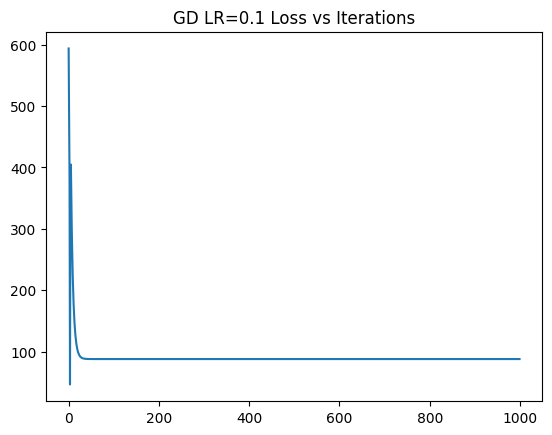

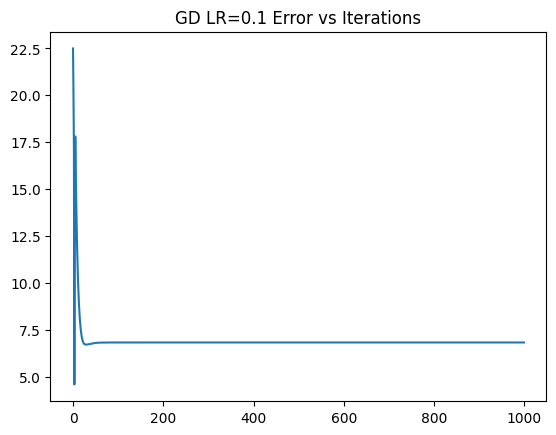

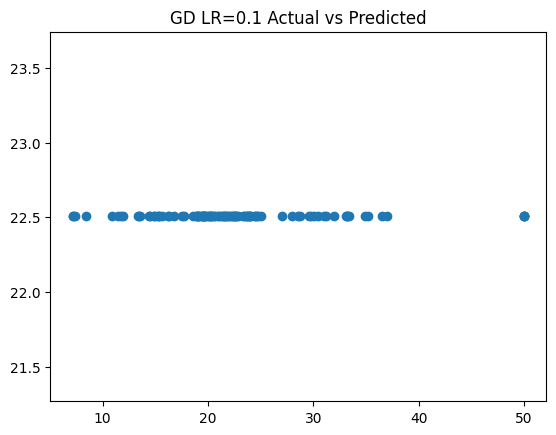


Learning Rate: 0.01
Final Train Loss: 9.078221591008242
Final Train Error: 2.232003736609949
Test MSE: 12.90123866830548
Confusion Matrix:
 [[ 0.  0.  0.  0.  0.]
 [ 0. 47.  5.  0.  0.]
 [ 0.  8. 35.  1.  0.]
 [ 0.  0.  2.  0.  0.]
 [ 0.  0.  1.  2.  1.]]


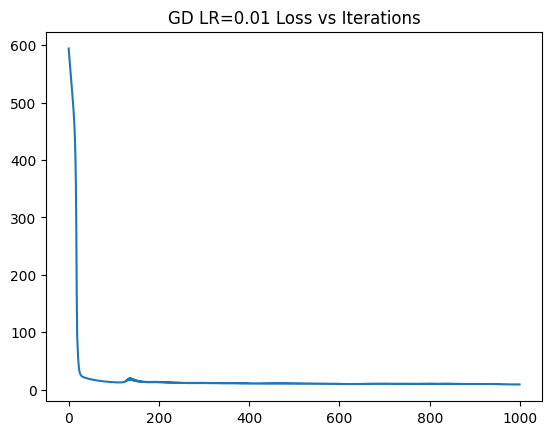

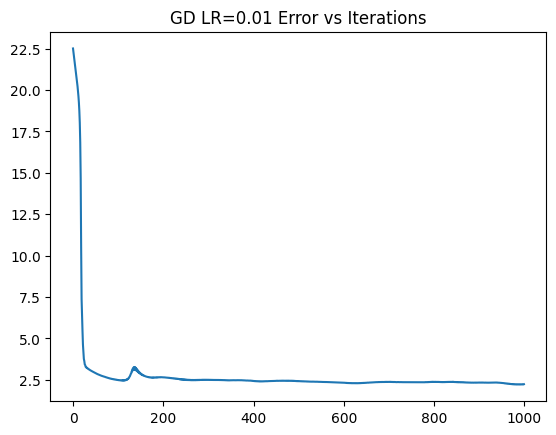

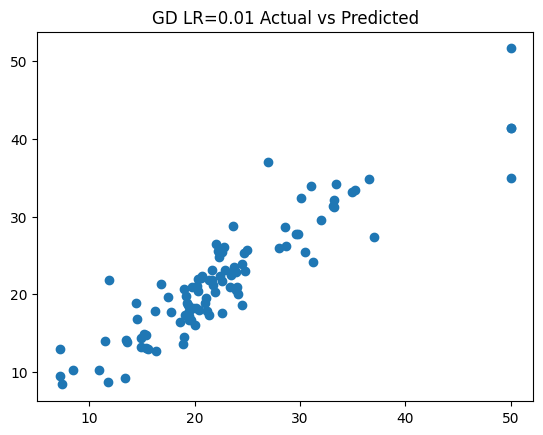


Learning Rate: 0.001
Final Train Loss: 11.831452828946734
Final Train Error: 2.3997279020945057
Test MSE: 13.976726815178775
Confusion Matrix:
 [[ 0.  0.  0.  0.  0.]
 [ 0. 46.  6.  0.  0.]
 [ 0.  9. 32.  3.  0.]
 [ 0.  0.  2.  0.  0.]
 [ 0.  0.  1.  3.  0.]]


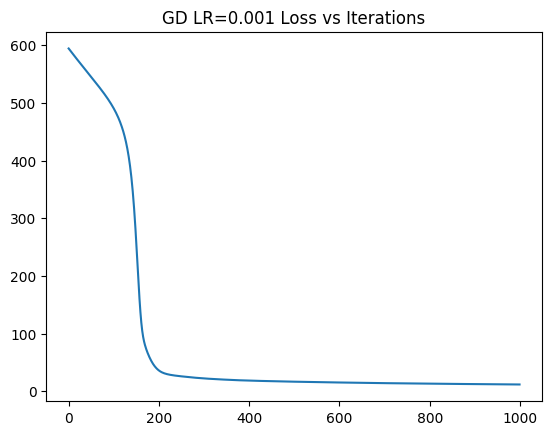

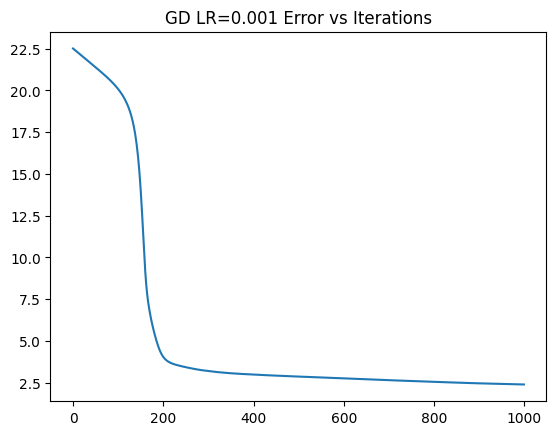

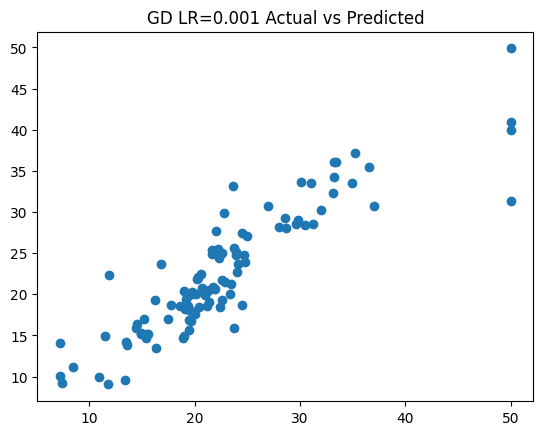

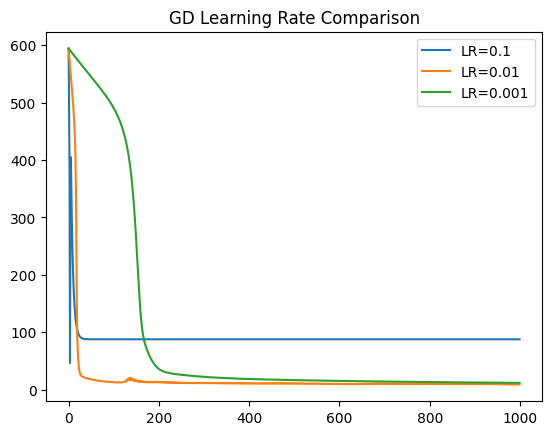

In [54]:
learning_rates = [0.1, 0.01, 0.001]
gd_results = {}
for lr in learning_rates:
    print("\nLearning Rate:", lr)
    
    model, losses, errors = train_model("gd", lr)
    yp_test = model.forward(X_test)
    mse = np.mean((yp_test - y_test)**2)

    bins = np.linspace(y_test.min(), y_test.max(), 4)
    y_true_bin = np.digitize(y_test.flatten(), bins)
    y_pred_bin = np.digitize(yp_test.flatten(), bins)

    cm = np.zeros((5,5))
    for i in range(len(y_true_bin)):
        cm[y_true_bin[i]][y_pred_bin[i]] += 1

    gd_results[lr] = losses

    print("Final Train Loss:", losses[-1])
    print("Final Train Error:", errors[-1])
    print("Test MSE:", mse)
    print("Confusion Matrix:\n", cm)

    plt.figure()
    plt.plot(losses)
    plt.title("GD LR=" + str(lr) + " Loss vs Iterations")
    plt.show()

    plt.figure()
    plt.plot(errors)
    plt.title("GD LR=" + str(lr) + " Error vs Iterations")
    plt.show()

    plt.figure()
    plt.scatter(y_test, yp_test)
    plt.title("GD LR=" + str(lr) + " Actual vs Predicted")
    plt.show()

plt.figure()
for lr in learning_rates:
    plt.plot(gd_results[lr], label="LR=" + str(lr))
plt.legend()
plt.title("GD Learning Rate Comparison")
plt.show()



Learning Rate: 0.1
Final Train Loss: 4.681642384660356
Final Train Error: 1.5613937263896775
Test MSE: 15.293985482602158
Confusion Matrix:
 [[ 0.  0.  0.  0.  0.]
 [ 0. 51.  1.  0.  0.]
 [ 0.  8. 32.  4.  0.]
 [ 0.  0.  1.  1.  0.]
 [ 0.  0.  1.  0.  3.]]


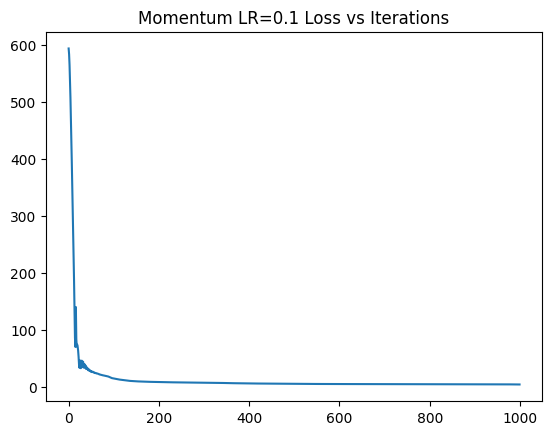

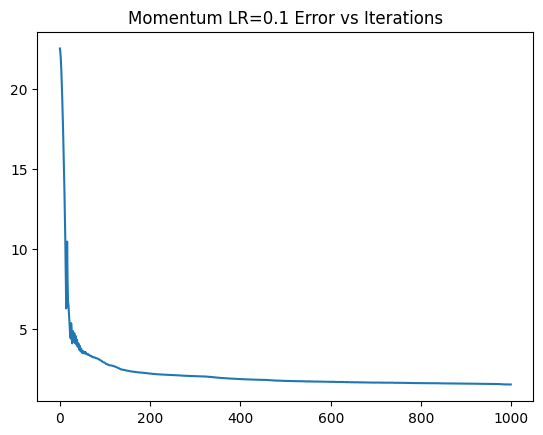

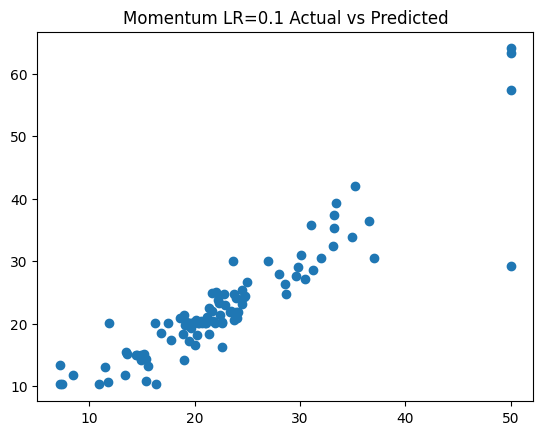


Learning Rate: 0.01
Final Train Loss: 6.998317409084739
Final Train Error: 1.9101915759674255
Test MSE: 12.390034349876826
Confusion Matrix:
 [[ 0.  0.  0.  0.  0.]
 [ 0. 47.  5.  0.  0.]
 [ 0.  6. 32.  6.  0.]
 [ 0.  0.  1.  1.  0.]
 [ 0.  0.  0.  3.  1.]]


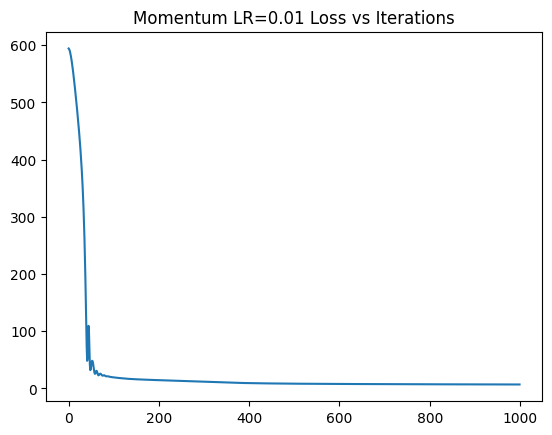

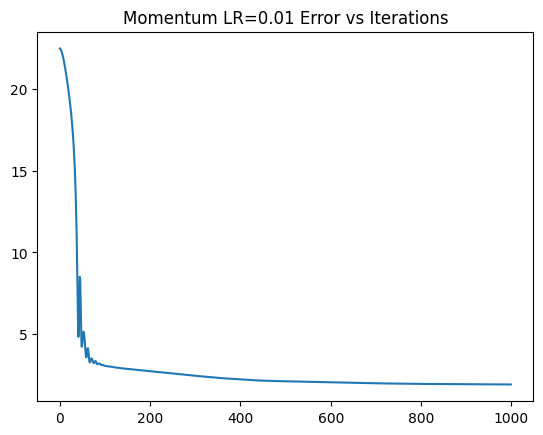

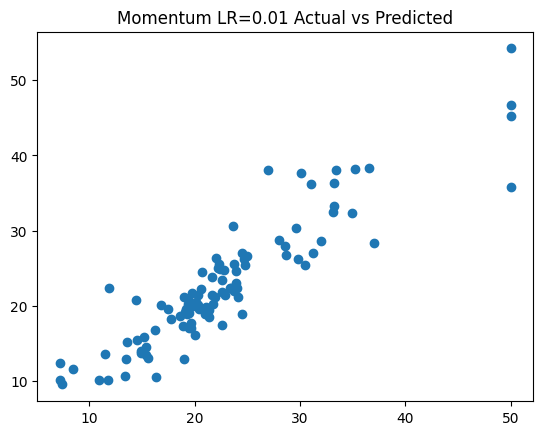


Learning Rate: 0.001
Final Train Loss: 13.096984091787856
Final Train Error: 2.5432857039921934
Test MSE: 16.694971642045676
Confusion Matrix:
 [[ 0.  0.  0.  0.  0.]
 [ 0. 45.  7.  0.  0.]
 [ 0.  6. 33.  5.  0.]
 [ 0.  0.  1.  1.  0.]
 [ 0.  0.  1.  2.  1.]]


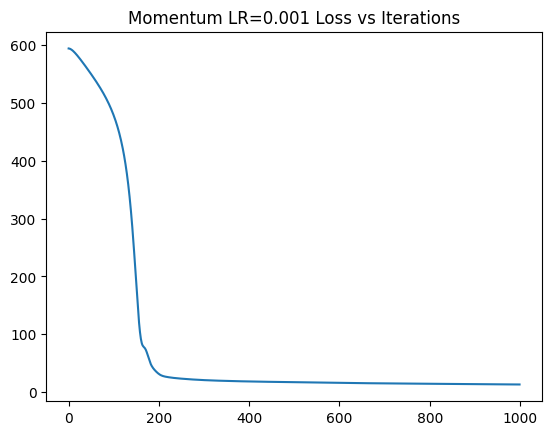

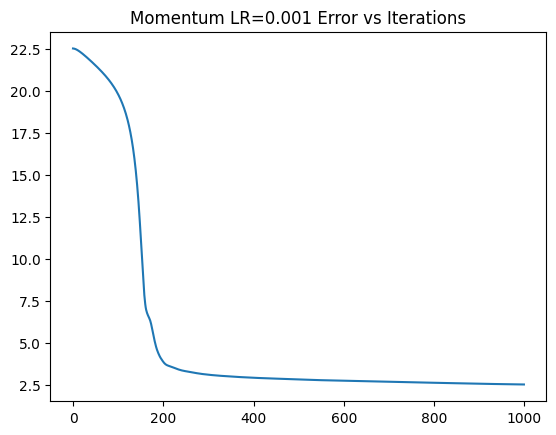

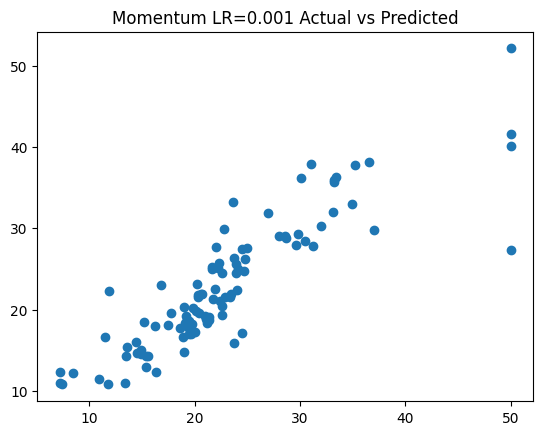

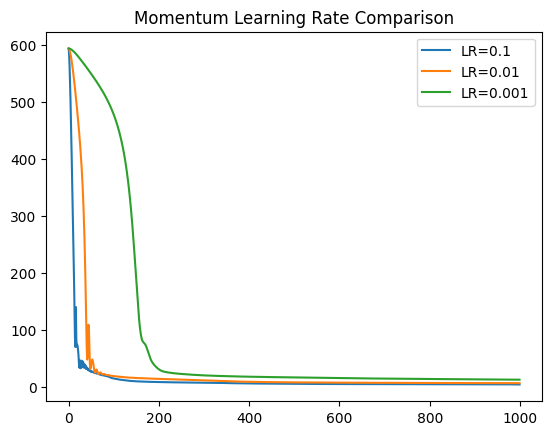

In [55]:
momentum_results = {}
for lr in learning_rates:
    print("\nLearning Rate:", lr)
    
    model, losses, errors = train_model("momentum", lr)
    yp_test = model.forward(X_test)
    mse = np.mean((yp_test - y_test)**2)

    y_pred_bin = np.digitize(yp_test.flatten(), bins)

    cm = np.zeros((5,5))
    for i in range(len(y_true_bin)):
        cm[y_true_bin[i]][y_pred_bin[i]] += 1

    momentum_results[lr] = losses

    print("Final Train Loss:", losses[-1])
    print("Final Train Error:", errors[-1])
    print("Test MSE:", mse)
    print("Confusion Matrix:\n", cm)

    plt.figure()
    plt.plot(losses)
    plt.title("Momentum LR=" + str(lr) + " Loss vs Iterations")
    plt.show()

    plt.figure()
    plt.plot(errors)
    plt.title("Momentum LR=" + str(lr) + " Error vs Iterations")
    plt.show()

    plt.figure()
    plt.scatter(y_test, yp_test)
    plt.title("Momentum LR=" + str(lr) + " Actual vs Predicted")
    plt.show()

plt.figure()
for lr in learning_rates:
    plt.plot(momentum_results[lr], label="LR=" + str(lr))
plt.legend()
plt.title("Momentum Learning Rate Comparison")
plt.show()



Learning Rate: 0.1
Final Train Loss: 5.327869939844623
Final Train Error: 1.736103716795564
Test MSE: 13.43622383245956
Confusion Matrix:
 [[ 0.  0.  0.  0.  0.]
 [ 0. 47.  5.  0.  0.]
 [ 0.  5. 37.  2.  0.]
 [ 0.  0.  2.  0.  0.]
 [ 0.  0.  1.  2.  1.]]


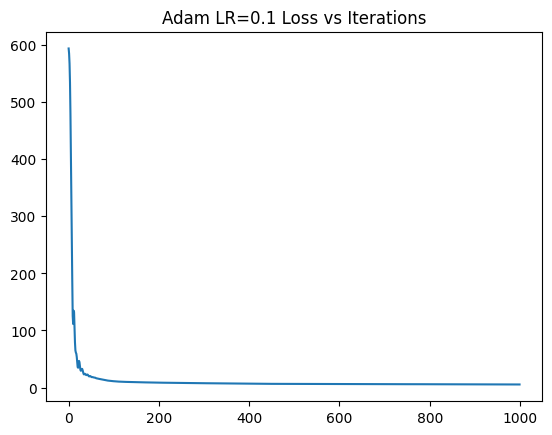

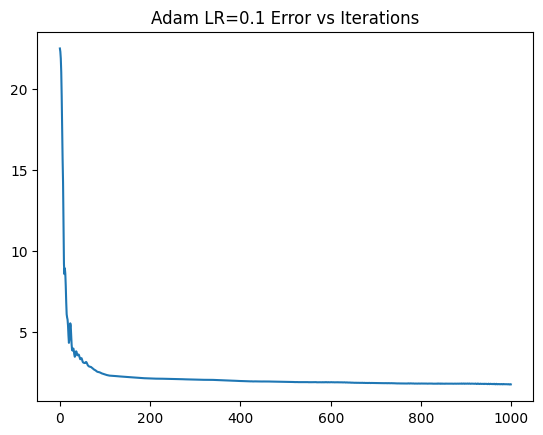

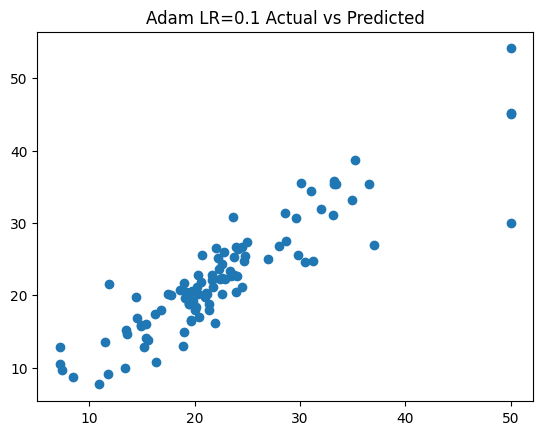


Learning Rate: 0.01
Final Train Loss: 8.300052353449967
Final Train Error: 2.0673541558573
Test MSE: 12.940647702210745
Confusion Matrix:
 [[ 0.  0.  0.  0.  0.]
 [ 0. 47.  5.  0.  0.]
 [ 0.  6. 35.  3.  0.]
 [ 0.  0.  2.  0.  0.]
 [ 0.  0.  1.  2.  1.]]


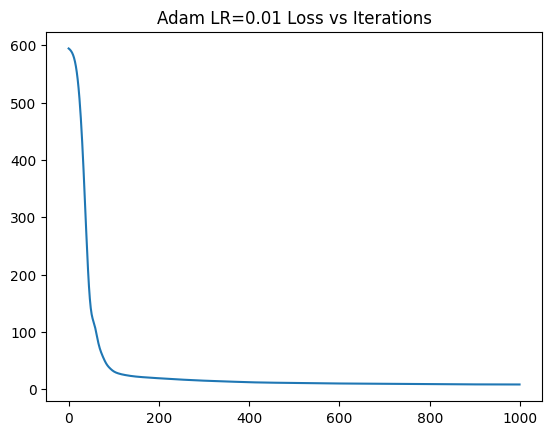

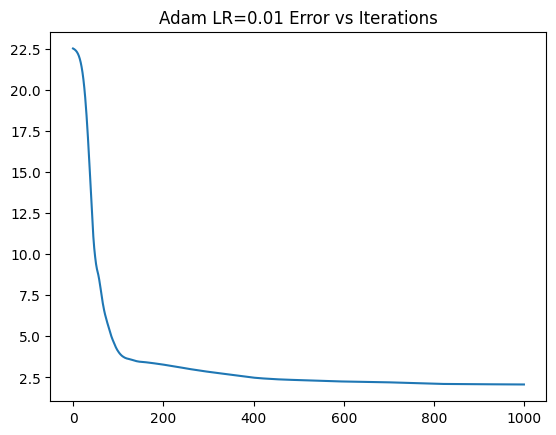

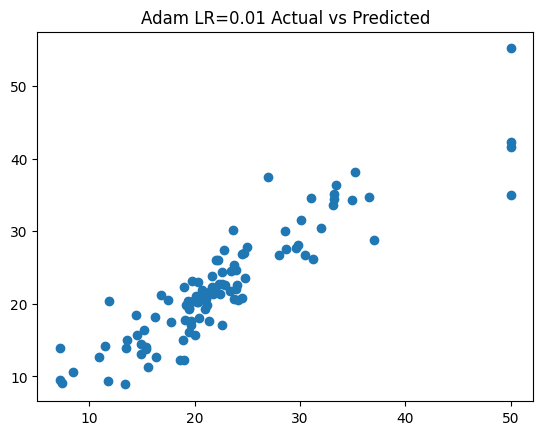


Learning Rate: 0.001
Final Train Loss: 24.663005454865313
Final Train Error: 3.5997501678927613
Test MSE: 31.039191038424352
Confusion Matrix:
 [[ 0.  0.  0.  0.  0.]
 [ 2. 42.  8.  0.  0.]
 [ 1.  8. 32.  3.  0.]
 [ 0.  0.  2.  0.  0.]
 [ 0.  0.  1.  3.  0.]]


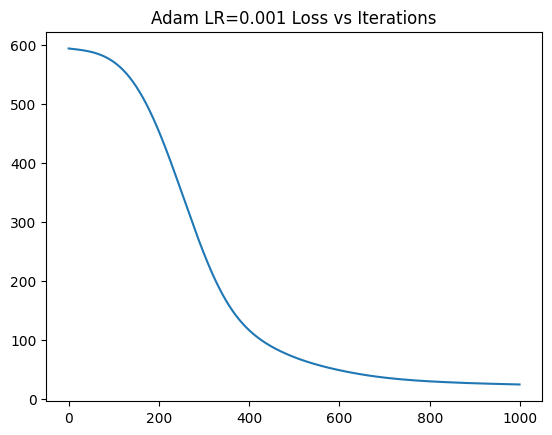

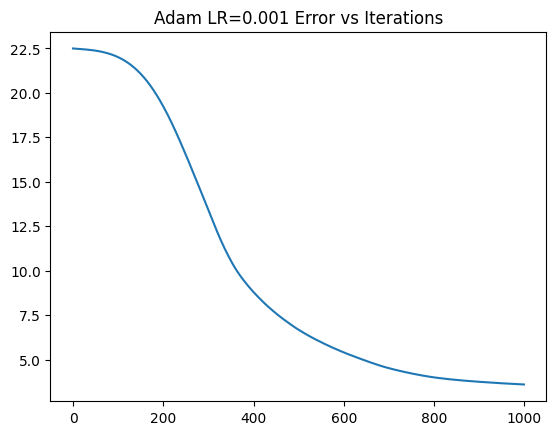

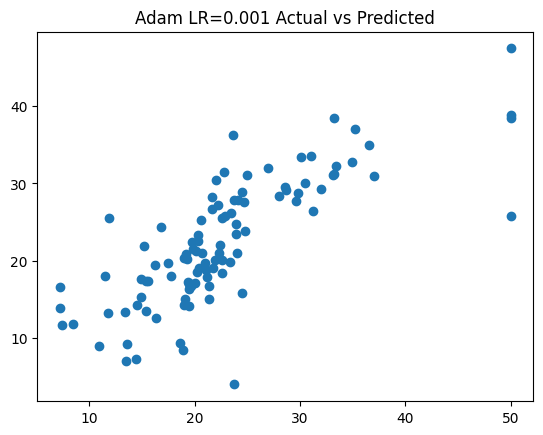

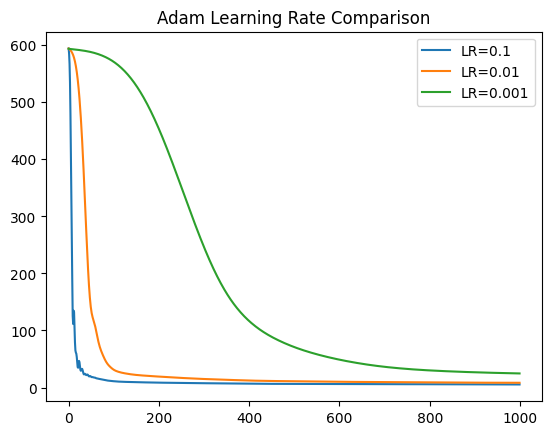

In [56]:
adam_results = {}
for lr in learning_rates:
    print("\nLearning Rate:", lr)
    
    model, losses, errors = train_model("adam", lr)
    yp_test = model.forward(X_test)
    mse = np.mean((yp_test - y_test)**2)

    y_pred_bin = np.digitize(yp_test.flatten(), bins)

    cm = np.zeros((5,5))
    for i in range(len(y_true_bin)):
        cm[y_true_bin[i]][y_pred_bin[i]] += 1

    adam_results[lr] = losses

    print("Final Train Loss:", losses[-1])
    print("Final Train Error:", errors[-1])
    print("Test MSE:", mse)
    print("Confusion Matrix:\n", cm)

    plt.figure()
    plt.plot(losses)
    plt.title("Adam LR=" + str(lr) + " Loss vs Iterations")
    plt.show()

    plt.figure()
    plt.plot(errors)
    plt.title("Adam LR=" + str(lr) + " Error vs Iterations")
    plt.show()

    plt.figure()
    plt.scatter(y_test, yp_test)
    plt.title("Adam LR=" + str(lr) + " Actual vs Predicted")
    plt.show()

plt.figure()
for lr in learning_rates:
    plt.plot(adam_results[lr], label="LR=" + str(lr))
plt.legend()
plt.title("Adam Learning Rate Comparison")
plt.show()


In [57]:
best_mse = float("inf")
best_config = None

print("Optimizer | Learning Rate | Final Loss | Test MSE")
print("---------------------------------------------------")

for opt in ["gd", "momentum", "adam"]:
    if opt == "gd":
        results_dict = gd_results
    elif opt == "momentum":
        results_dict = momentum_results
    else:
        results_dict = adam_results

    for lr in learning_rates:
        model, losses, errors = train_model(opt, lr)
        yp_test = model.forward(X_test)
        mse = np.mean((yp_test - y_test)**2)

        print(opt, " | ", lr, " | ", losses[-1], " | ", mse)

        if mse < best_mse:
            best_mse = mse
            best_config = (opt, lr)

print("\nBest Configuration:")
print("Optimizer:", best_config[0])
print("Learning Rate:", best_config[1])
print("Best Test MSE:", best_mse)


Optimizer | Learning Rate | Final Loss | Test MSE
---------------------------------------------------
gd  |  0.1  |  87.75301214341731  |  71.22010278572266
gd  |  0.01  |  7.5146832458784765  |  10.604198607806449
gd  |  0.001  |  11.276472118388458  |  13.51158592712347
momentum  |  0.1  |  87.75301214341731  |  71.22010278572266
momentum  |  0.01  |  7.5210752284839515  |  10.872665542455517
momentum  |  0.001  |  12.469588223979715  |  13.965216148104787
adam  |  0.1  |  6.391727427025373  |  13.17944594052335
adam  |  0.01  |  8.49027842585653  |  12.467945772480848
adam  |  0.001  |  21.547998687213557  |  27.68620993275711

Best Configuration:
Optimizer: gd
Learning Rate: 0.01
Best Test MSE: 10.604198607806449


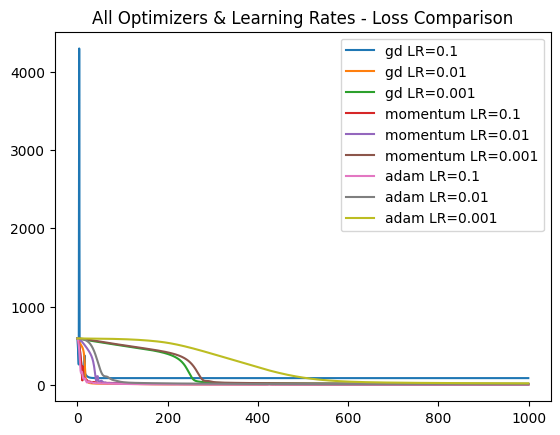

In [58]:
plt.figure()

for opt in ["gd", "momentum", "adam"]:
    for lr in learning_rates:
        model, losses, errors = train_model(opt, lr)
        label_name = opt + " LR=" + str(lr)
        plt.plot(losses, label=label_name)

plt.legend()
plt.title("All Optimizers & Learning Rates - Loss Comparison")
plt.show()


Bonus 1

In [59]:
class MLP3:
    def __init__(self, lr=0.01):
        self.lr = lr
        
        self.W1 = np.random.randn(13,7)*0.1
        self.b1 = np.zeros((1,7))
        
        self.W2 = np.random.randn(7,5)*0.1
        self.b2 = np.zeros((1,5))
        
        self.W3 = np.random.randn(5,2)*0.1
        self.b3 = np.zeros((1,2))
        
        self.W4 = np.random.randn(2,1)*0.1
        self.b4 = np.zeros((1,1))

    def forward(self, X):
        self.z1 = X@self.W1 + self.b1
        self.a1 = relu(self.z1)
        
        self.z2 = self.a1@self.W2 + self.b2
        self.a2 = relu(self.z2)
        
        self.z3 = self.a2@self.W3 + self.b3
        self.a3 = relu(self.z3)
        
        self.z4 = self.a3@self.W4 + self.b4
        
        return self.z4

    def train(self, X, y):
        losses = []
        
        for epoch in range(1000):
            yp = self.forward(X)
            loss = np.mean((yp - y)**2)
            losses.append(loss)
            
            m = X.shape[0]
            
            dz4 = (yp - y)/m
            dW4 = self.a3.T@dz4
            db4 = np.sum(dz4, axis=0, keepdims=True)
            
            da3 = dz4@self.W4.T
            dz3 = da3*drelu(self.z3)
            dW3 = self.a2.T@dz3
            db3 = np.sum(dz3, axis=0, keepdims=True)
            
            da2 = dz3@self.W3.T
            dz2 = da2*drelu(self.z2)
            dW2 = self.a1.T@dz2
            db2 = np.sum(dz2, axis=0, keepdims=True)
            
            da1 = dz2@self.W2.T
            dz1 = da1*drelu(self.z1)
            dW1 = X.T@dz1
            db1 = np.sum(dz1, axis=0, keepdims=True)
            
            self.W4 -= self.lr*dW4
            self.b4 -= self.lr*db4
            self.W3 -= self.lr*dW3
            self.b3 -= self.lr*db3
            self.W2 -= self.lr*dW2
            self.b2 -= self.lr*db2
            self.W1 -= self.lr*dW1
            self.b1 -= self.lr*db1
        
        return losses


Final Train Loss: 10.12098119957984
Test MSE: 13.41349250481207


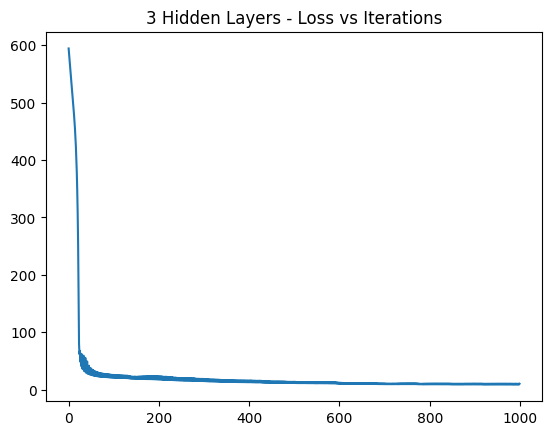

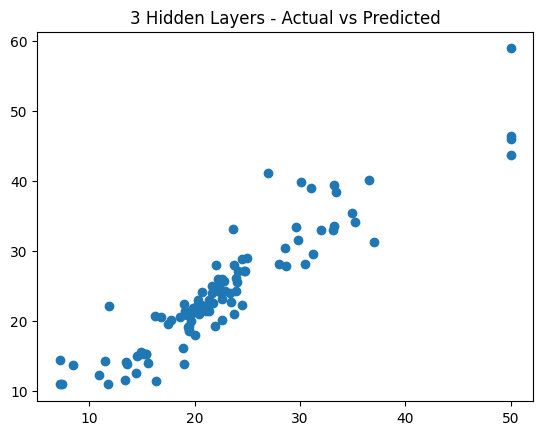

In [60]:
model_3layer = MLP3(lr=0.01)
losses_3layer = model_3layer.train(X_train, y_train)

yp_test_3layer = model_3layer.forward(X_test)
mse_3layer = np.mean((yp_test_3layer - y_test)**2)
print("Final Train Loss:", losses_3layer[-1])
print("Test MSE:", mse_3layer)

plt.figure()
plt.plot(losses_3layer)
plt.title("3 Hidden Layers - Loss vs Iterations")
plt.show()

plt.figure()
plt.scatter(y_test, yp_test_3layer)
plt.title("3 Hidden Layers - Actual vs Predicted")
plt.show()


In [63]:
def train_model_l2(opt, lr, l2):
    model = MLP(lr=lr, optimizer=opt, l2=l2)
    losses = []
    errors = []
    
    for epoch in range(1000):
        yp = model.forward(X_train)
        loss = np.mean((yp - y_train)**2)
        error = np.mean(np.abs(yp - y_train))
        
        grads = model.backward(X_train, y_train, yp)
        model.update(grads)
        
        losses.append(loss)
        errors.append(error)
        
    return model, losses, errors
model_l2, losses_l2, errors_l2 = train_model_l2("gd", 0.01, 0.01)


Final Train Loss: 8.716321253178734
Test MSE: 13.311216328131971


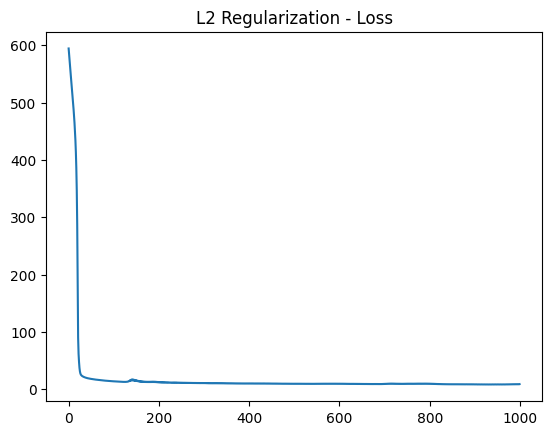

In [65]:
yp_test_l2 = model_l2.forward(X_test)
mse_l2 = np.mean((yp_test_l2 - y_test)**2)
print("Final Train Loss:", losses_l2[-1])
print("Test MSE:", mse_l2)

plt.figure()
plt.plot(losses_l2)
plt.title("L2 Regularization - Loss")
plt.show()


========== ARCHITECTURE COMPARISON ==========
2 Hidden Layers Test MSE: 11.14668353960276
3 Hidden Layers Test MSE: 13.41349250481207


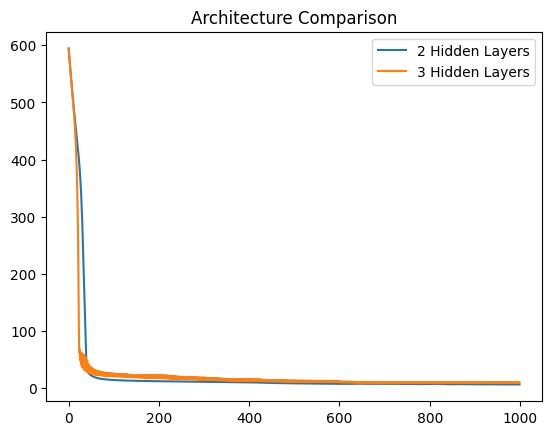

In [66]:
print("2 Hidden Layers Test MSE:", mse_gd)
print("3 Hidden Layers Test MSE:", mse_3layer)

plt.figure()
plt.plot(losses_gd, label="2 Hidden Layers")
plt.plot(losses_3layer, label="3 Hidden Layers")
plt.legend()
plt.title("Architecture Comparison")
plt.show()



========== REGULARIZATION COMPARISON ==========
Without L2 Test MSE: 11.14668353960276
With L2 Test MSE: 13.311216328131971


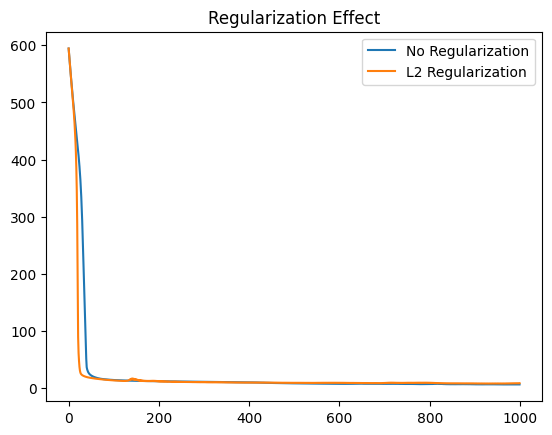

In [67]:
print("Without L2 Test MSE:", mse_gd)
print("With L2 Test MSE:", mse_l2)

plt.figure()
plt.plot(losses_gd, label="No Regularization")
plt.plot(losses_l2, label="L2 Regularization")
plt.legend()
plt.title("Regularization Effect")
plt.show()
